**What we are going to output**
1. Is cancer or Not cancer
2. Which type of cancer (bcc, mel) or non-cancer (akiec, bkl, df, nv, vasc)


M(1) ---> P(Cancer)


M(2) ---> Max ( P(cancer_type_1),  P(cancertype_2) ... P(cancertype_n) )


M(3) ---> Max ( P(benign_type_1),  P(benign_type_2) ... P(benign_type_n) )

In [5]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS_442_Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

sys.path.append(GOOGLE_DRIVE_PATH)
print(GOOGLE_DRIVE_PATH)

# Change into project drive directory.
%cd /content/drive/MyDrive/EECS_442_Project/

ModuleNotFoundError: No module named 'google.colab'

Checks which device we are using.

Note: This code has been pulled from Homework 5: hw5_diffusion.ipynb

In [1]:
import torch

# GPUs are preferred
device_str = f"cuda:0" if torch.cuda.is_available() else 'cpu'
print("Current device: ", device_str)
device = torch.device(device_str)

Current device:  cuda:0


### Compress Images (Preprocessing) - DONT RUN!
Converts images from: /content/drive/MyDrive/EECS_442_Project/data/images/

This function does the following:
- For each image, resive the 600x450 image to 300x300
- Set the quality to 90
- Reduces image size from 180KB to 11KB with minimal loss in program accuracy.


In [2]:
from PIL import Image
import os

# directory for the original images and the new directory for the reduced images
original_images_path = '/content/drive/MyDrive/EECS_442_Project/data/images/'
reduced_images_dir = '/content/drive/MyDrive/EECS_442_Project/data/images_compressed/'

# Create the directory for reduced images if it does not exist
os.makedirs(reduced_images_dir, exist_ok=True)

# Define the desired size and quality
desired_size = (300, 300)
quality_setting = 90

# Function to process images
def process_images(image_directory, output_directory, size, quality):
    # Iterate over all the files in the original image directory
    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # Construct the full file path
            file_path = os.path.join(original_images_path)
            try:
                # Open the image
                image = Image.open(file_path)

                # Resize the image
                image_resized = image.resize(size)

                # Construct the output file path
                output_file_path = os.path.join(output_directory, 'out-'+str(size)+'-'+str(quality)+'.jpg')

                # Save the image with optimization and the set quality
                image_resized.save(output_file_path, optimize=True, quality=quality)

                print(f'Processed {output_file_path}')
            except Exception as e:
                print(f'Error processing {original_images_path}: {e}')

# Call the function
#process_images(original_images_path, reduced_images_dir, desired_size, quality_setting)


In [ ]:
#image_files = [f for f in os.listdir(reduced_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
# print(len(image_files))
# import os

def get_dir_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

# Replace 'reduced_images_dir' with the actual path of your directory
# total_size = get_dir_size(original_images_path)
# print(f"The total size of the folder is: {total_size} bytes")
# print(f"The total size of the folder is: {total_size / (1024**2):.2f} MB")

10167
The total size of the folder is: 2811403003 bytes
The total size of the folder is: 2681.16 MB


### ImageData Class
Converts images from: /content/drive/MyDrive/EECS_442_Project/data/images/ to Tensors.

This class stores the following:
- Image_id/name Ex. 'ISIC_0030208'
- Classification Ex. 'bkl'


In [4]:
import csv
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

class ImageData(Dataset):
  def __init__(self, preprocess=False, dataset_type='complete', training_type='training'):
    self.preprocess = preprocess
    self.root = 'data/images/'
    self.cancerous_path = 'data/cancerous_HAM10000_metadata.csv'
    self.non_cancerous_path = 'data/non_cancerous_HAM10000_metadata.csv'
    self.complete_path = 'data/partitioned_HAM10000_metadata.csv'
#     self.complete_path = 'data/evenmore_downsampled_partitioned.csv'
    self.transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Resize((224, 224))
      ])

    path = None
    if dataset_type == 'complete':
      path = self.complete_path
    elif dataset_type == 'cancerous':
      path = self.cancerous_path
    elif dataset_type == 'non_cancerous':
      path = self.non_cancerous_path
    else:
      print("Please define path as: complete, cancerous, or non_cancerous")

    self.image_id_list = []
    # Initialize a dictionary of metadata.
    self.image_metadata_dict = {}
    label_dict = {
        'training': 'validation',
        'validation': 'test',
        'test': ''
    }


    found_type = False
    with open(path, mode='r') as file:
      metadata = csv.reader(file)
      for row in metadata:
        if row[0] == training_type:
          found_type = True
          continue
        elif not found_type:
          continue

        if row[0] == label_dict[training_type]:
          break

        found_type = True
        image_id = row[1]
        classification = row[2] # Corresponds to the dx column in the metadata csv
        self.image_metadata_dict[image_id] = classification
        self.image_id_list.append(image_id)


  def __len__(self):
    return len(self.image_metadata_dict)

  def __getitem__(self, idx):
    image_path = self.root + self.image_id_list[idx] + ".jpg"
    image = Image.open(image_path).convert("RGB")
    image = self.transform(image)
    # print(self.preprocess)
    if self.preprocess:
      # Calculate image mean and normalize here.
      mean = torch.mean(image, dim=(1, 2))
      std = torch.std(image, dim=(1, 2))
      preprocess_transform = transforms.Compose([
        transforms.RandomRotation(degrees=(-30, 30)),
#         transforms.Normalize(mean=mean, std=std),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1))
      ])
      image = preprocess_transform(image)
    classification = self.image_metadata_dict[self.image_id_list[idx]]
    image_id = self.image_id_list[idx]
    return image_id, classification, image.to(device)

### DataLoader
Creates a dataloader for our ImageData dataset class.

Run this to check that data is loading in properly, and that the names and classifications are being correctly associated.

## Guide to using the DataLoader
This gives you 3 vectors, each of length batch size.\
`for names, classifications, images in training_data:`\
This loops through the 3 vectors and gives you the specific image as well as the name and classification corresponding to that image.\
`for name, classification, image in zip(names, classifications, images):`


There are 3 different data loaders: training_data, validation_data, and test_data.

In [5]:
Preprocess = False # True 
print_preview = True

Printing training data batch.
Image name:  ISIC_0026342  Image Classification:  nv


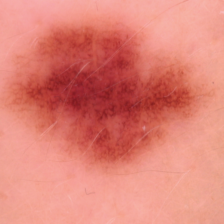



Printing validation data batch.
Image name:  ISIC_0025793  Image Classification:  bcc


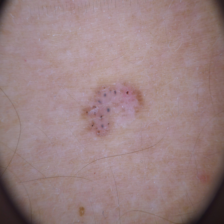

In [6]:
from torch.utils.data import DataLoader

# Tunable Parameters:
batch_size = 1
shuffle = True

training = ImageData(preprocess=Preprocess, dataset_type='complete', training_type='training')
training_data = DataLoader(dataset=training, batch_size=batch_size, shuffle=shuffle)

validation = ImageData(preprocess=Preprocess, dataset_type='complete', training_type='validation')
validation_data = DataLoader(dataset=validation, batch_size=batch_size, shuffle=shuffle)

# test = ImageData(preprocess=Preprocess, dataset_type='complete', training_type='test')
# test_data = DataLoader(dataset=test, batch_size=batch_size, shuffle=shuffle)

if print_preview:
  # Images will be of batch size.
  names, classifications, images = next(iter(training_data))
  print('Printing training data batch.')
  for name, classification, image in zip(names, classifications, images):
    print("Image name: ", name, " Image Classification: ", classification)
    convert_to_PIL = transforms.ToPILImage()
    img = convert_to_PIL(image)
    display(img)
    print('\n')

  names, classifications, images = next(iter(validation_data))
  print('Printing validation data batch.')
  for name, classification, image in zip(names, classifications, images):
    print("Image name: ", name, " Image Classification: ", classification)
    convert_to_PIL = transforms.ToPILImage()
    img = convert_to_PIL(image)
    display(img)
    print('\n')

#   names, classifications, images = next(iter(test_data))
#   print('Printing test data batch.')
#   for name, classification, image in zip(names, classifications, images):
#     print("Image name: ", name, " Image Classification: ", classification)
#     convert_to_PIL = transforms.ToPILImage()
#     img = convert_to_PIL(image)
#     display(img)
#     print('\n')




## Setup

In [16]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import seaborn as sns


# The First Model (Our design)

- Used to detect malignant vs. benign.
- Predicts: probability of cell being cancerous
- Architecture: 5 convolutional blocks


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()

        self.features = nn.Sequential(
        # Block 1
        nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Convolutional layer with 3 input channels (RGB) and 32 output channels
        nn.ReLU(),                                    # ReLU activation function to introduce non-linearity
        nn.MaxPool2d(2, 2),                           # Max pooling layer to downsample the feature maps
        nn.Dropout(0.25),                             # Dropout layer to prevent overfitting by randomly dropping connections

        # Block 2
        nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional layer with 32 input channels and 64 output channels
        nn.ReLU(),                                    # ReLU activation function
        nn.MaxPool2d(2, 2),                           # Max pooling
        nn.Dropout(0.25),                             # Dropout

        # Block 3
        nn.Conv2d(64, 128, kernel_size=3, padding=1), # Convolutional layer with 64 input channels and 128 output channels
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Block 4
        nn.Conv2d(128, 256, kernel_size=3, padding=1), # Convolutional layer with 128 input channels and 256 output channels
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Block 5
        nn.Conv2d(256, 512, kernel_size=3, padding=1), # Convolutional layer with 256 input channels and 512 output channels
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),
        )

        # Define the fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),                 # Fully connected layer with input size of 512*7*7 and output size of 1024
            nn.ReLU(),                                    # ReLU activation function
            nn.Dropout(0.25),                             # Dropout

            nn.Linear(1024, 1),                           # Fully connected layer with input size of 1024 and output size of 1
            nn.Sigmoid()                                  # Sigmoid activation function to output likelihood of cancer
        )
#         self.classifier = nn.Sequential(
            
# #             nn.Linear(512 * 9 * 9, 1024),  # Adjusted the input features
#             nn.ReLU(),
#             nn.Dropout(0.25),
#             nn.Linear(1024, 1),
#             nn.Sigmoid()
#         )

    def forward(self, x):
        # Pass the input through the convolutional blocks
        x = self.features(x)
#         print(x.shape)
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        # Pass the output through the fully connected layers
        x = self.classifier(x)
        return x

In [39]:
# training = ImageData(preprocess=Preprocess, dataset_type='complete', training_type='training')
# filtered_training_data = DataLoader(dataset=training, batch_size=batch_size, shuffle=shuffle)

# validation = ImageData(preprocess=Preprocess, dataset_type='complete', training_type='validation')
# validation_data = DataLoader(dataset=validation, batch_size=batch_size, shuffle=shuffle)


# filtered_training_data = filtered_training_data
# validation_data = validation_data

## Downsampling nc data:


In [35]:
# mport csv
# from torch.utils.data import Dataset
# import torchvision.transforms as transforms
# from PIL import Image

# class ImageData(Dataset):
#   def __init__(self, preprocess=False, dataset_type='complete', training_type='training', downsample_nc=False):  # Add the downsample_nc parameter here
#     self.preprocess = preprocess
#     self.root = 'data/images/'
#     self.cancerous_path = 'data/cancerous_HAM10000_metadata.csv'
#     self.non_cancerous_path = 'data/non_cancerous_HAM10000_metadata.csv'
#     self.complete_path = 'data/partitioned_HAM10000_metadata.csv'
#     self.transform = transforms.Compose([
#         transforms.PILToTensor(),
#         transforms.ConvertImageDtype(torch.float),
#         transforms.Resize((224, 224))
#     ])

#     # Determine the path based on dataset_type
#     path = self.complete_path if dataset_type == 'complete' else \
#            self.cancerous_path if dataset_type == 'cancerous' else \
#            self.non_cancerous_path if dataset_type == 'non_cancerous' else \
#            None

#     self.image_data = []  # Use this list to store all image data
#     label_dict = {'training': 'validation', 'validation': 'test', 'test': ''}

#     with open(path, mode='r') as file:
#       metadata = csv.reader(file)
#       next(metadata)  # Skip the header
#       for row in metadata:
#         if row[0] == training_type:
#           self.image_data.append((row[1], row[2], self.root + row[1] + ".jpg"))
#         elif row[0] == label_dict[training_type]:
#           break  # Stop when we reach the end of the current training type section
        
#     if training_type == 'training' and downsample_nc:
#       self.downsample_nc()
            
#   def downsample_nc(self):
#     # Separate 'nc' class data and other data
#     nc_data = [item for item in self.image_data if item[1] == 'nc']
#     other_data = [item for item in self.image_data if item[1] != 'nc']

#     # Downsample 'nc' data to 50% of its original size
#     reduced_nc_data = random.sample(nc_data, len(nc_data) // 2)

#     # Combine and shuffle
#     self.image_data = other_data + reduced_nc_data
#     random.shuffle(self.image_data)


#   def __len__(self):
#     return len(self.image_data) 

#   def __getitem__(self, idx):
#     image_id, classification, image_path = self.image_data[idx]
#     image = Image.open(image_path).convert("RGB")
#     image = self.transform(image)
    
#     if self.preprocess:
#         # Apply preprocess transformations (normalization, etc.)
#         # Note that you might need to move and reshape the image tensor for normalization.
#         mean = torch.mean(image, dim=(1, 2))
#         std = torch.std(image, dim=(1, 2))
#         preprocess_transform = transforms.Compose([
#             transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
#             transforms.GaussianBlur(kernel_size=3, sigma=(0.1))
#         ])
#         image = preprocess_transform(image)

#     return image_id, classification, image


# training_data = ImageData(preprocess=True, dataset_type='complete', training_type='training', downsample_nc=True)
# validation_data = ImageData(preprocess=True, dataset_type='complete', training_type='validation')
# test_data = ImageData(preprocess=True, dataset_type='complete', training_type='test')


# Alternative model: LeNet

In [24]:
class LeNetBinaryClassifier(nn.Module):
    def __init__(self, input_size=(224, 224)):
        super(LeNetBinaryClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Calculate the size of the output from the last conv/pooling block.
        def conv_output_size(img_size, padding, kernel_size, stride):
            return (img_size + 2*padding - (kernel_size - 1) - 1) // stride  + 1
        
        # Calculations assuming the input image is a square of size initial_size x initial_size
        size = conv_output_size(input_size[0], 0, 5, 1)  # conv1: (224-5)/1 + 1 = 220
        size = conv_output_size(size, 0, 2, 2)           # pool1: (220-2)/2 + 1 = 110
        size = conv_output_size(size, 0, 5, 1)           # conv2: (110-5)/1 + 1 = 106
        size = conv_output_size(size, 0, 2, 2)           # pool2: (106-2)/2 + 1 = 53

        self.fc1 = nn.Linear(16 * size * size, 120)      # Adjust the input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [12]:
# # TODO: Adjust input dimensions

# model1 = LeNetBinaryClassifier(input_size=(224, 224)).to(device)
model1 = FirstModel().to(device)

batch_size = 128
shuffle = True


training = ImageData(preprocess=Preprocess, dataset_type='complete', training_type='training')
training_data = DataLoader(dataset=training, batch_size=batch_size, shuffle=shuffle)

validation = ImageData(preprocess=Preprocess, dataset_type='complete', training_type='validation')
validation_data = DataLoader(dataset=validation, batch_size=batch_size, shuffle=shuffle)

lr = .001
num_epochs = 3

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

# Train:

training_accuracies = []
validation_accuracies = []

# Train:
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0

    for batch in tqdm(training_data):
        _, labels, images = batch
        num_labels = torch.tensor([1 if (label == 'mel' or label == 'bcc') else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, num_labels)
        loss.backward()
        optimizer.step()
        
        predicted = (outputs > 0).float()
        total += num_labels.size(0)
        correct += (predicted == num_labels).sum().item()

        running_loss += loss.item()
        i += 1
        
    # Store the average training accuracy for the current epoch
    train_accuracy = 100 * correct / total
    print(f"Epoch:{epoch}, training accuracy: {train_accuracy}")
    training_accuracies.append(train_accuracy)
    
    model1.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in validation_data:
            _, labels, images = batch

            num_labels = torch.tensor([1 if (label == 'mel' or label == 'bcc') else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
    #         print(images.shape) 
            outputs = model1(images)
            predicted = (outputs > 0).float()

            total += num_labels.size(0)
            correct += (predicted == num_labels).sum().item()

        val_accuracy = 100 * correct / total
        validation_accuracies.append(val_accuracy)
        print(f"Correct: {correct}; Total: {total}")
        print(f'Validation Accuracy: {val_accuracy:.2f}%')


100%|██████████| 55/55 [01:32<00:00,  1.68s/it]


Epoch:0, training accuracy: 87.13858424725822
Correct: 881; Total: 988
Validation Accuracy: 89.17%


100%|██████████| 55/55 [01:31<00:00,  1.66s/it]


Epoch:1, training accuracy: 89.81626548924655
Correct: 881; Total: 988
Validation Accuracy: 89.17%


100%|██████████| 55/55 [01:31<00:00,  1.66s/it]


Epoch:2, training accuracy: 89.81626548924655
Correct: 881; Total: 988
Validation Accuracy: 89.17%


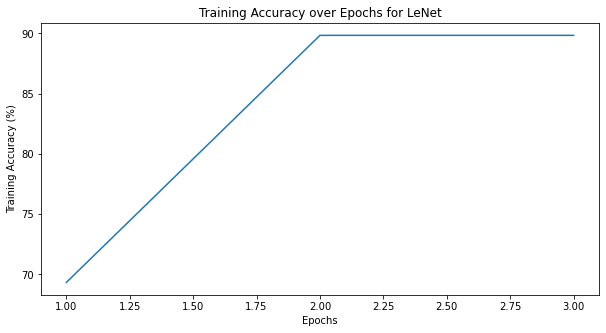

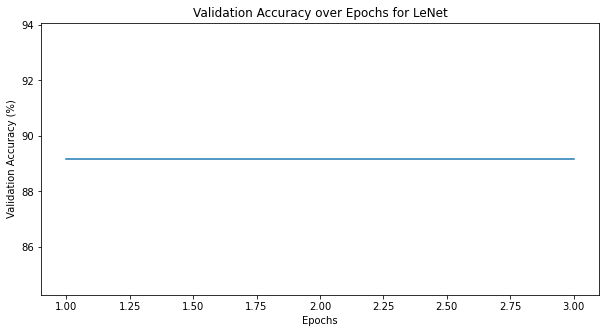

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, num_epochs+1), y=training_accuracies)
plt.title('Training Accuracy over Epochs for LeNet')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.savefig('model1_train_acc_original_lenet.png')
plt.show()


# Plot validation accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, num_epochs+1), y=validation_accuracies)
plt.title('Validation Accuracy over Epochs for LeNet')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()


In [6]:
# model = model_2_with_residual().to(device)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 5

# # Lists for tracking accuracy
# training_accuracies = []
# validation_accuracies = []

# # Training loop
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     train_correct = 0
#     train_total = 0

#     for batch in tqdm(training_data, desc='Training Epoch {}'.format(epoch+1)):
#         _, labels, images = batch
#         images = images.to(device)
#         # Convert labels to a tensor of 0s and 1s
#         num_labels = torch.tensor([1 if label == 'mel' or label == 'bcc' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
        
#         optimizer.zero_grad()
        
#         outputs = model(images)
#         loss = criterion(outputs, num_labels)
#         loss.backward()
#         optimizer.step()
        
#         predicted = torch.round(torch.sigmoid(outputs))
#         train_total += num_labels.size(0)
#         train_correct += (predicted == num_labels).sum().item()

#     train_accuracy = 100 * train_correct / train_total
#     training_accuracies.append(train_accuracy)
    
#     # Validation phase
#     model.eval()
#     valid_correct = 0
#     valid_total = 0
    
#     with torch.no_grad():
#         for batch in tqdm(validation_data, desc='Validation Epoch {}'.format(epoch+1)):
#             _, labels, images = batch
#             images = images.to(device)
#             num_labels = torch.tensor([1 if label == 'mel' or label == 'bcc' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
            
#             outputs = model(images)
#             predicted = torch.round(torch.sigmoid(outputs))
#             valid_total += num_labels.size(0)
#             valid_correct += (predicted == num_labels).sum().item()

#     valid_accuracy = 100 * valid_correct / valid_total
#     validation_accuracies.append(valid_accuracy)
    
#     # Print accuracies for the epoch
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')

# # Plotting the training and validation accuracies
# plt.figure(figsize=(10, 5))
# sns.lineplot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
# sns.lineplot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
# plt.title('Training and Validation Accuracies')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.show()


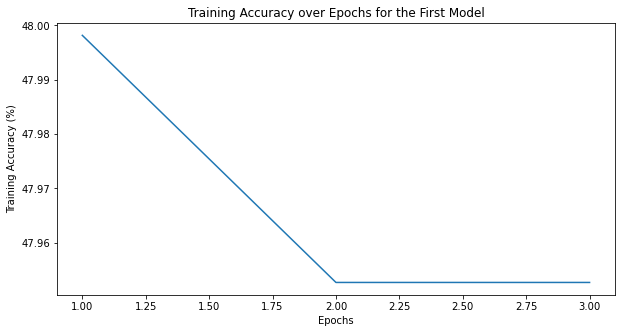

In [25]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, num_epochs+1), y=training_accuracies)
plt.title('Training Accuracy over Epochs for the First Model')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.savefig('model1_train_acc_downsampled_our_model.png')
plt.show()

# Class breakdown:

In [13]:
from collections import Counter

def check_class_distribution(data_loader):
    label_counter = Counter()
    for _, labels, _ in data_loader:
        label_counter.update(labels)
    return label_counter

# Use check_class_distribution on your training_data and validation_data
train_class_dist = check_class_distribution(training_data)
val_class_dist = check_class_distribution(validation_data)

print("Training set class distribution:", train_class_dist)
print("Validation set class distribution:", val_class_dist)


/opt/anaconda/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training set class distribution: Counter({'nv': 4726, 'bkl': 1249, 'mel': 363, 'bcc': 352, 'akiec': 234, 'vasc': 97})
Validation set class distribution: Counter({'nv': 691, 'bkl': 148, 'bcc': 61, 'mel': 46, 'akiec': 27, 'vasc': 15})


In [31]:
# from sklearn.metrics import f1_score

# model.eval()

# # Lists to store all true labels and predicted labels for the validation dataset
# all_true_labels = []
# all_pred_labels = []

# with torch.no_grad():
#     for batch in validation_data:
#         _, labels, images = batch
#         num_labels = torch.tensor([1 if (label == 'mel' or label == 'bcc') else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
#         outputs = model(images)
        
#         # Since outputs are logits, apply sigmoid and then threshold at 0.5 for binary classification
#         preds = torch.sigmoid(outputs) > 0.5
        
#         # Move predictions and true labels to CPU and convert them to NumPy arrays
#         preds = preds.cpu().numpy()
#         labels_np = num_labels.cpu().numpy()
        
#         # Extend the lists with the flattened arrays
#         all_true_labels.extend(labels_np.flatten())
#         all_pred_labels.extend(preds.flatten())

# # Calculate F1 score
# f1 = f1_score(all_true_labels, all_pred_labels)
# print(f'Validation F1 Score: {f1:.4f}')


# **The second model:**
- Used if the first model which cancer (bcc or mel)
- Predict which type of cancer it is.

Architecture:
1. Input layer: 224, 224, 3

2. Convolutional blocks: (mayebe 3)
  - Block 1:  
    - filters=32, kernel_size=(3, 3), activation='relu', padding='same' - activation and kernel size are subject to change
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)) - subject to change
    - Dropout(0.1) - dropout rate is subject to change
    
  - Block 2:
    - filters=64, kernel_size=(3, 3), activation='relu', padding='same' - activation and kernel size are subject to change
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)),
    - Dropout(0.25) - dropout rate is subject to change

  - Block 3 (last block):
    - Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)),
    - Dropout(0.25),

3. Fully connected layer (after flatten the output from convolutional layer):
  - Dense(256, activation='relu'),
  - Dropout(0.2)

4. Output:
  - Dense(num_classes, activation='softmax')

<!-- class Network(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
  
    def forward(self, x):
       
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        return x -->

In [6]:
from torch.utils.data import DataLoader

# Tunable Parameters:
batch_size = 128
shuffle = True


training = ImageData(preprocess=Preprocess, dataset_type='cancerous', training_type='training')
training_data = DataLoader(dataset=training, batch_size=batch_size, shuffle=shuffle)

validation = ImageData(preprocess=Preprocess, dataset_type='cancerous', training_type='validation')
validation_data = DataLoader(dataset=validation, batch_size=batch_size, shuffle=shuffle)

test = ImageData(preprocess=Preprocess, dataset_type='cancerous', training_type='test')
test_data = DataLoader(dataset=test, batch_size=batch_size, shuffle=shuffle)

# Model 2 without residual connection:

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
# add residual connection
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2)
        )

        self.fc = nn.Sequential(
            nn.Linear(100352, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return torch.sigmoid(out)


# Model2 architecture with residual connection

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class model_2_with_residual(nn.Module):
    def __init__(self):
        super(model_2_with_residual, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        # Adjustment for channel increase and potential size difference in residual connection
        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride=2, bias=False),  # Stride set to 2 for spatial size reduction
            nn.BatchNorm2d(128)
        )
        self.residual_block = ResidualBlock(64, 128, stride=2, downsample=self.downsample)

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),  # Adjusted input channels to 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(25088, 256), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

        # You will need to recalculate the size here based on your network's architecture
#         self.fc = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, 1)
#         )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.residual_block(out)  # Applying the residual block
        out = self.block3(out)         # Additional layers after the residual block

        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)               # Fully connected layer operation
        return out
    

# Train and validate model 2 With Residual:

In [13]:
model = model_2_with_residual().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Lists for tracking accuracy
training_accuracies = []
validation_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_correct = 0
    train_total = 0

    for batch in tqdm(training_data, desc='Training Epoch {}'.format(epoch+1)):
        _, labels, images = batch
        images = images.to(device)
        # Convert labels to a tensor of 0s and 1s
        num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, num_labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.round(torch.sigmoid(outputs))
        train_total += num_labels.size(0)
        train_correct += (predicted == num_labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    training_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():
        for batch in tqdm(validation_data, desc='Validation Epoch {}'.format(epoch+1)):
            _, labels, images = batch
            images = images.to(device)
            num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
            
            outputs = model(images)
            predicted = torch.round(torch.sigmoid(outputs))
            valid_total += num_labels.size(0)
            valid_correct += (predicted == num_labels).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total
    validation_accuracies.append(valid_accuracy)
    
    # Print accuracies for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')


Validation Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch [1/10], Train Accuracy: 69.88%, Validation Accuracy: 27.44%


Validation Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Epoch [2/10], Train Accuracy: 84.44%, Validation Accuracy: 31.10%


Validation Epoch 3: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Epoch [3/10], Train Accuracy: 83.51%, Validation Accuracy: 58.54%


Validation Epoch 4: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Epoch [4/10], Train Accuracy: 85.82%, Validation Accuracy: 79.88%


Validation Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Epoch [5/10], Train Accuracy: 87.21%, Validation Accuracy: 84.15%


Validation Epoch 6: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Epoch [6/10], Train Accuracy: 87.52%, Validation Accuracy: 85.37%


Validation Epoch 7: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Epoch [7/10], Train Accuracy: 88.21%, Validation Accuracy: 85.37%


Validation Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch [8/10], Train Accuracy: 88.98%, Validation Accuracy: 86.59%


Validation Epoch 9: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Epoch [9/10], Train Accuracy: 87.98%, Validation Accuracy: 84.15%


Validation Epoch 10: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

Epoch [10/10], Train Accuracy: 88.91%, Validation Accuracy: 85.98%


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


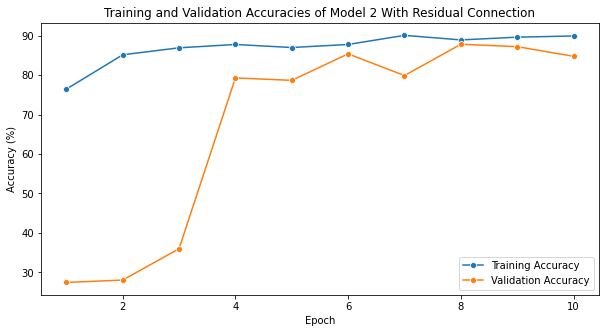

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
sns.lineplot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracies of Model 2 With Residual Connection')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('train_valid_acc_model_2_residual.png')
plt.show()

# Train and validate model 2 without residual:

In [9]:
model = model2().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Lists for tracking accuracy
training_accuracies = []
validation_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_correct = 0
    train_total = 0

    for batch in tqdm(training_data, desc='Training Epoch {}'.format(epoch+1)):
        _, labels, images = batch
        images = images.to(device)
        # Convert labels to a tensor of 0s and 1s
        num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, num_labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.round(torch.sigmoid(outputs))
        train_total += num_labels.size(0)
        train_correct += (predicted == num_labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    training_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():
        for batch in tqdm(validation_data, desc='Validation Epoch {}'.format(epoch+1)):
            _, labels, images = batch
            images = images.to(device)
            num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
            
            outputs = model(images)
            predicted = torch.round(torch.sigmoid(outputs))
            valid_total += num_labels.size(0)
            valid_correct += (predicted == num_labels).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total
    validation_accuracies.append(valid_accuracy)
    
    # Print accuracies for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')



Validation Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Epoch [1/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Epoch [2/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 3: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Epoch [3/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 4: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Epoch [4/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Epoch [5/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 6: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Epoch [6/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 7: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Epoch [7/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Epoch [8/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 9: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Epoch [9/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


Validation Epoch 10: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

Epoch [10/10], Train Accuracy: 68.57%, Validation Accuracy: 72.56%


In [49]:
# from collections import Counter

# def check_class_distribution(data_loader):
#     label_counter = Counter()
#     for _, labels, _ in data_loader:
#         label_counter.update(labels)
#     return label_counter

# # Use check_class_distribution on your training_data and validation_data
# train_class_dist = check_class_distribution(training_data)
# val_class_dist = check_class_distribution(validation_data)
# test_class_dist = check_class_distribution(test_data)

# print("Training set class distribution:", train_class_dist)
# print("Validation set class distribution:", val_class_dist)
# print("Test set class distribution:", test_class_dist)


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


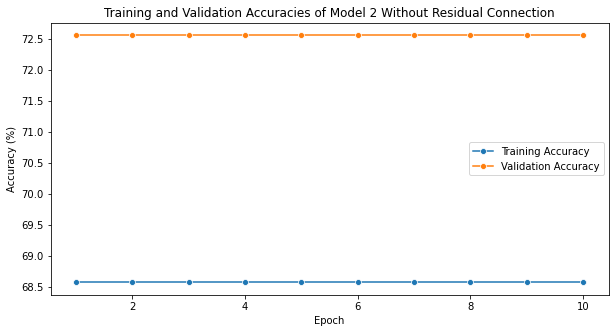

In [11]:
plt.figure(figsize=(10, 5))
sns.lineplot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
sns.lineplot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracies of Model 2 Without Residual Connection')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('train_valid_acc_model_2_no_residual.png')
plt.show()

# plt.figure(figsize=(10, 5))
# sns.lineplot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
# plt.title('Validation Accuracy of Model 2 Without Residual Connection')

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.savefig('valid_acc_model_2.png')
# plt.show()


# Evaluate on test set

In [14]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in tqdm(test_data):
        _, labels, images = batch
        images = images.to(device)
        num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)

        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        test_total += num_labels.size(0)
        test_correct += (predicted == num_labels).sum().item()

test_accuracy = 100 * test_correct / test_total

# Print accuracies for the epoch
print(f'Test Accuracy: {test_accuracy:.2f}%')


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

Test Accuracy: 87.27%


# With preprocessing:

# With residual:

In [9]:
model = model_2_with_residual().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Lists for tracking accuracy
training_accuracies = []
validation_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_correct = 0
    train_total = 0

    for batch in tqdm(training_data, desc='Training Epoch {}'.format(epoch+1)):
        _, labels, images = batch
        images = images.to(device)
        # Convert labels to a tensor of 0s and 1s
        num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, num_labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.round(torch.sigmoid(outputs))
        train_total += num_labels.size(0)
        train_correct += (predicted == num_labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    training_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():
        for batch in tqdm(validation_data, desc='Validation Epoch {}'.format(epoch+1)):
            _, labels, images = batch
            images = images.to(device)
            num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
            
            outputs = model(images)
            predicted = torch.round(torch.sigmoid(outputs))
            valid_total += num_labels.size(0)
            valid_correct += (predicted == num_labels).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total
    validation_accuracies.append(valid_accuracy)
    
    # Print accuracies for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')



Validation Epoch 1: 100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Epoch [1/10], Train Accuracy: 62.63%, Validation Accuracy: 28.05%


Validation Epoch 2: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


Epoch [2/10], Train Accuracy: 77.89%, Validation Accuracy: 40.85%


Validation Epoch 3: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


Epoch [3/10], Train Accuracy: 78.58%, Validation Accuracy: 75.00%


Validation Epoch 4: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


Epoch [4/10], Train Accuracy: 83.98%, Validation Accuracy: 82.32%


Validation Epoch 5: 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


Epoch [5/10], Train Accuracy: 86.21%, Validation Accuracy: 85.37%


Validation Epoch 6: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Epoch [6/10], Train Accuracy: 86.83%, Validation Accuracy: 89.02%


Validation Epoch 7: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Epoch [7/10], Train Accuracy: 87.13%, Validation Accuracy: 85.37%


Validation Epoch 8: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Epoch [8/10], Train Accuracy: 86.75%, Validation Accuracy: 88.41%


Validation Epoch 9: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Epoch [9/10], Train Accuracy: 87.60%, Validation Accuracy: 88.41%


Validation Epoch 10: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

Epoch [10/10], Train Accuracy: 87.98%, Validation Accuracy: 86.59%


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


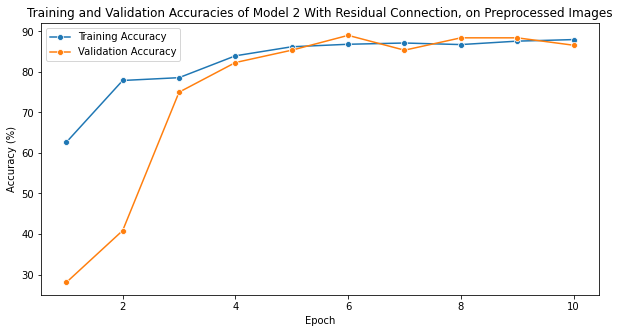

In [10]:
# Plotting the training and validation accuracies

plt.figure(figsize=(10, 5))
sns.lineplot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
sns.lineplot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracies of Model 2 With Residual Connection, on Preprocessed Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('train_valid_acc_model_2_residual_preprocessed.png')
plt.show()


In [11]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in tqdm(test_data):
        _, labels, images = batch
        images = images.to(device)
        num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)

        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        test_total += num_labels.size(0)
        test_correct += (predicted == num_labels).sum().item()

test_accuracy = 100 * test_correct / test_total

# Print accuracies for the epoch
print(f'Test Accuracy: {test_accuracy:.2f}%')


100%|██████████| 2/2 [00:05<00:00,  2.61s/it]

Test Accuracy: 85.45%


# Without residuals:

In [20]:

model = model2().to(device)
count_mel = 890
count_bcc = 408

# Total count
total_count = count_mel + count_bcc

# Calculate class weights for 'mel' and 'bcc'
weight_mel = total_count / (2 * count_mel)
weight_bcc = total_count / (2 * count_bcc)

# Use the higher weight for the less represented class
# Assuming 'bcc' is the class of interest (the positive class)
class_weight = weight_bcc

# Convert class weights to a tensor
class_weight_tensor = torch.tensor(class_weight, dtype=torch.float).to(device)

# Use this weight on your BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight_tensor)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Lists for tracking accuracy
training_accuracies = []
validation_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_correct = 0
    train_total = 0

    for batch in tqdm(training_data, desc='Training Epoch {}'.format(epoch+1)):
        _, labels, images = batch
        images = images.to(device)
        # Convert labels to a tensor of 0s and 1s
        num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, num_labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.round(torch.sigmoid(outputs))
        train_total += num_labels.size(0)
        train_correct += (predicted == num_labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    training_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():
        for batch in tqdm(validation_data, desc='Validation Epoch {}'.format(epoch+1)):
            _, labels, images = batch
            images = images.to(device)
            num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)
            
            outputs = model(images)
            predicted = torch.round(torch.sigmoid(outputs))
            valid_total += num_labels.size(0)
            valid_correct += (predicted == num_labels).sum().item()

    valid_accuracy = 100 * valid_correct / valid_total
    validation_accuracies.append(valid_accuracy)
    
    # Print accuracies for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')



In [17]:
# Plotting the training and validation accuracies

plt.figure(figsize=(10, 5))
sns.lineplot(range(1, num_epochs + 1), training_accuracies, marker='o', label='Training Accuracy')
sns.lineplot(range(1, num_epochs + 1), validation_accuracies, marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracies of Model 2 Without Residual Connection, on Preprocessed Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('train_valid_acc_model_2_no_residual_preprocessed.png')
plt.show()


In [16]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in tqdm(test_data):
        _, labels, images = batch
        images = images.to(device)
        num_labels = torch.tensor([1 if label == 'mel' else 0 for label in labels], dtype=torch.float32).to(device).unsqueeze(1)

        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        test_total += num_labels.size(0)
        test_correct += (predicted == num_labels).sum().item()

test_accuracy = 100 * test_correct / test_total

# Print accuracies for the epoch
print(f'Test Accuracy: {test_accuracy:.2f}%')


100%|██████████| 2/2 [00:05<00:00,  2.52s/it]

Test Accuracy: 63.03%


# **The third model:**

*   Used if the first model outputs non-cancerous
*   Classifies which non-cancerous skin lesion

We can test on existing models and our own and contrast ????
Break data down into:
- 80% training
- 10% validation
- 10% testing

Small dataset

Hyper-parameters (To be Tuned):
- Batch Size: 32
- Learning Rate: 1e-4
- Decay Factor / L2 Reg: 0.0001
- Optimizer: Adam (momentum for GD)
- Epochs: 20

Architecture:
1. Pre-process images:
    - rescale to 224x224x3
    - normalize to center around 0 (divide each pixel by 255)
    - smooth it out

2. Input Image: 224x224x3

3. Convolutional blocks: (5 of them)
  - Block 1:  
    - filters=560, kernel_size=(3, 3), activation='relu', padding='same' - activation and kernel size are subject to change
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)) - subject to change
    - Dropout(0.1) - dropout rate is subject to change
    
  - Block 2:
    - filters=280, kernel_size=(3, 3), activation='relu', padding='same' - activation and kernel size are subject to change
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)),
    - Dropout(0.25) - dropout rate is subject to change

  - Block 3:
    - Conv2D(filters=140, kernel_size=(3, 3), activation='relu', padding='same'),
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)),
    - Dropout(0.25),
  - Block 4:
    - Conv2D(filters=70, kernel_size=(3, 3), activation='relu', padding='same'),
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)),
    - Dropout(0.25),
  - Block 5:
    - Conv2D(filters=35, kernel_size=(3, 3), activation='relu', padding='same'),
    - BatchNormalization(),
    - MaxPooling2D(pool_size=(2, 2)),
    - Dropout(0.25),

3. Fully connected layer (after flatten the output from convolutional layer):
  - Dense(256, activation='relu'),
  - Dropout(0.2)

4. Output:
  - Dense(num_classes, activation='softmax')

Things to calculate:
- Accuracy: TP + TN / TP + TN + FP + FN
- Recall: TP / TP + TN
- Precision: TP / TP + FP


## Set Up Hyperparameters

In [9]:
# Tunable Parameters:
batch_size = 128
learning_rate, weight_decay, num_epochs = 0.001, 0.01, 3

## Load Data

In [10]:
from torch.utils.data import DataLoader
shuffle = True

training = ImageData(preprocess=Preprocess, dataset_type='non_cancerous', training_type='training')
training_data = DataLoader(dataset=training, batch_size=batch_size, shuffle=shuffle)

validation = ImageData(preprocess=Preprocess, dataset_type='non_cancerous', training_type='validation')
validation_data = DataLoader(dataset=validation, batch_size=batch_size, shuffle=shuffle)

test = ImageData(preprocess=Preprocess, dataset_type='non_cancerous', training_type='test')
test_data = DataLoader(dataset=test, batch_size=batch_size, shuffle=shuffle)

nc_labels = ['akiec', 'bkl', 'df', 'nv', 'vasc']


## Model 3 without Residual Connection

In [11]:
# import torch.nn as nn
import torch.nn.functional as F

class model3(nn.Module):
    def __init__(self):
        super(model3, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        # should be  32x112x112

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        # should be 64x56x56
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2)
        )

        # 128x28x28

        self.fc = nn.Sequential(
            nn.Linear(100352, 256), #18432
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 5)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # x = self.block4(x)
        # x = self.block5(x)

        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.fc(x)
        return F.softmax(x, dim=1)


# Model 3 with residual connection:

In [18]:
class ResidualBlock_model3(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock_model3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class model3_residual(nn.Module):
    def __init__(self):
        super(model3_residual, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        # should be  32x112x112

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        )
        self.residual_block = ResidualBlock_model3(64, 128, stride=2, downsample=self.downsample)

        # Assuming block3 remains the same as before
        self.block3 = nn.Sequential(
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(0.2)
      )

        self.fc = nn.Sequential(
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 5)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.residual_block(x)
        x = self.block3(x)

        x = x.view(x.size(0), -1)
#         print(x.size())
        x = self.fc(x)
        return x


# Evaluate function




In [33]:
# def evaluate(model, loader):  # Evaluate accuracy on validation set
#     print(len(loader.dataset))
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     with torch.no_grad():
#         for batch in tqdm(loader):
#             _, labels, images = batch
#             # batch = batch.to(device)
#             # label = label.to(device)
#             pred = model(images)
#             # print(labels)
#             # label = labels[0]
#             for label, prediction in zip(labels, pred):
#               correct += (nc_labels[torch.argmax(prediction)] == label)
#         acc = correct/len(loader.dataset)
#         print("\n Evaluation accuracy: {}".format(acc))
#         return acc


# Train model 3 without residual connection:

In [13]:
# Train:
print("Start training...")
criterion = nn.CrossEntropyLoss()
model = model3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

trn_loss_hist = []
trn_acc_hist = []
val_loss_hist = []  # Initialize validation loss history
val_acc_hist = []

for epoch in range(num_epochs):
    model.train()
    running_loss = []
    total_correct = 0  # Initialize total correct predictions
    total_samples = 0  # Initialize total samples

    print('-----------------Epoch = %d-----------------' % (epoch+1))

    for batch in tqdm(training_data):
        _, labels, images = batch
        optimizer.zero_grad()
        pred = model(images)

        label_index = [nc_labels.index(label) for label in labels]  # Convert labels to indices
        label_tensor = torch.tensor(label_index, dtype=torch.long).to(device)
        loss = criterion(pred, label_tensor)

        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        total_correct += (predicted == label_tensor).sum().item()
        total_samples += label_tensor.size(0)

    # Calculate average training loss for the epoch
    epoch_loss = np.mean(running_loss)
    trn_loss_hist.append(epoch_loss)

    # Calculate accuracy for the epoch
    epoch_acc = 100 * total_correct / total_samples
    trn_acc_hist.append(epoch_acc)

    # Print epoch statistics
    print("\n Epoch {} loss:{:.4f}, Accuracy: {:.2f}%".format(epoch+1, epoch_loss, epoch_acc))

    # Validation phase (similar to the previous example)
    print("\n Evaluate on validation set...")
    val_loss = 0.0  # Initialize validation loss accumulator
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(validation_data):
            _, labels, images = batch
            images = images.to(device)
            label_indices = [nc_labels.index(label) for label in labels]
            label_tensor = torch.tensor(label_indices, dtype=torch.long).to(device)
            outputs = model(images)
            loss = criterion(outputs, label_tensor)
            val_loss += loss.item()  # Accumulate validation loss

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += label_tensor.size(0)
            val_correct += (predicted == label_tensor).sum().item()

    val_loss /= len(validation_data)  # Calculate average validation loss
    val_loss_hist.append(val_loss)  # Store average validation loss
    val_acc = 100 * val_correct / val_total
    val_acc_hist.append(val_acc)

    # Print validation statistics
    print(f'Validation Loss: {val_loss:.4f})
    print("Done!")


Start training...
-----------------Epoch = 1-----------------


100%|██████████| 53/53 [01:27<00:00,  1.66s/it]



 Epoch 1 loss:1.1126, Accuracy: 79.13%

 Evaluate on validation set...


100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


Validation Loss: 1.1012, Validation Accuracy: 80.79%
Done!
-----------------Epoch = 2-----------------


100%|██████████| 53/53 [01:31<00:00,  1.73s/it]



 Epoch 2 loss:1.1036, Accuracy: 80.03%

 Evaluate on validation set...


100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


Validation Loss: 1.0919, Validation Accuracy: 80.79%
Done!
-----------------Epoch = 3-----------------


100%|██████████| 53/53 [01:30<00:00,  1.71s/it]



 Epoch 3 loss:1.1053, Accuracy: 80.03%

 Evaluate on validation set...


100%|██████████| 7/7 [00:10<00:00,  1.51s/it]

Validation Loss: 1.0938, Validation Accuracy: 80.79%
Done!


## PLOT

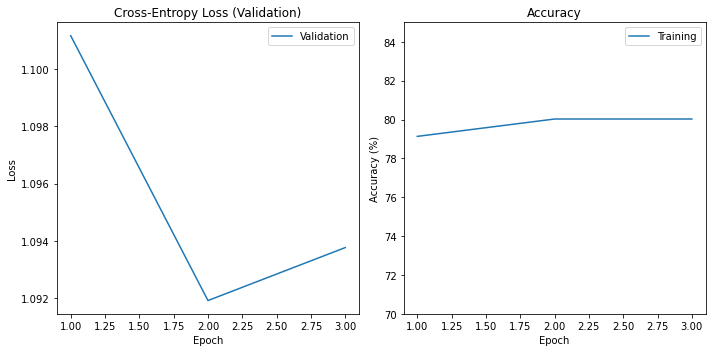

In [14]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross-Entropy Loss (Validation)')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), trn_acc_hist, label='Training')
# plt.plot(range(1, num_epochs + 1), val_acc_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')
plt.ylim(70, 85)

plt.tight_layout()
plt.show()


# Train model 3 with residual connection:

In [16]:
# model3_residual = model3_residual().to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# trn_loss_hist = []
# trn_acc_hist = []
# val_loss_hist = []
# val_acc_hist = []

# # Training loop
# for epoch in range(num_epochs):
#     model3_residual.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for i, batch in enumerate(tqdm(training_data)):
#         _, labels, images = batch
#         images = images.to(device)
#         label_indices = [nc_labels.index(label) for label in labels]
#         label_tensor = torch.tensor(label_indices, dtype=torch.long).to(device)
#         optimizer.zero_grad()
#         outputs = model3_residual(images)
#         loss = criterion(outputs, label_tensor)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#         # Calculate accuracy
#         _, predicted = torch.max(outputs, 1)
#         total += label_tensor.size(0)
#         correct += (predicted == label_tensor).sum().item()

#         # Print minibatch loss every 5 minibatches
# #         if i % 5 == 0:
# #             print('[Epoch %d, Minibatch %5d] loss: %.4f' %
# #                   (epoch + 1, i + 1, running_loss / 5))
# #             running_loss = 0.0

#     # Calculate average loss and accuracy for training data
#     avg_loss = running_loss / len(training_data)
#     trn_loss_hist.append(avg_loss)
#     trn_acc = 100 * correct / total
#     trn_acc_hist.append(trn_acc)

#     # Evaluate on validation data
#     model3_residual.eval()
#     val_running_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for batch in tqdm(validation_data):
#             _, labels, images = batch
#             images = images.to(device)
#             label_indices = [nc_labels.index(label) for label in labels]
#             label_tensor = torch.tensor(label_indices, dtype=torch.long).to(device)
#             outputs = model3_residual(images)
#             loss = criterion(outputs, label_tensor)
#             val_running_loss += loss.item()

#             # Calculate accuracy
#             _, predicted = torch.max(outputs, 1)
#             val_total += label_tensor.size(0)
#             val_correct += (predicted == label_tensor).sum().item()

#     # Calculate average loss and accuracy for validation data
#     val_avg_loss = val_running_loss / len(validation_data)
#     val_loss_hist.append(val_avg_loss)
#     val_acc = 100 * val_correct / val_total
#     val_acc_hist.append(val_acc)

#     # Print epoch statistics
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {trn_acc:.2f}%')
#     print(f'Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')


In [19]:
# Train:
print("Start training...")
criterion = nn.CrossEntropyLoss()
model3_residual = model3_residual().to(device)
optimizer = torch.optim.Adam(model3_residual.parameters(), lr=learning_rate, weight_decay=weight_decay)

trn_loss_hist = []
trn_acc_hist = []
val_loss_hist = []  # Initialize validation loss history
val_acc_hist = []

for epoch in range(num_epochs):
    model3_residual.train()
    running_loss = []
    total_correct = 0  # Initialize total correct predictions
    total_samples = 0  # Initialize total samples

    print('-----------------Epoch = %d-----------------' % (epoch+1))

    for batch in tqdm(training_data):
        _, labels, images = batch
        optimizer.zero_grad()
        pred = model3_residual(images)

        label_index = [nc_labels.index(label) for label in labels]  # Convert labels to indices
        label_tensor = torch.tensor(label_index, dtype=torch.long).to(device)
        loss = criterion(pred, label_tensor)

        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        total_correct += (predicted == label_tensor).sum().item()
        total_samples += label_tensor.size(0)

    # Calculate average training loss for the epoch
    epoch_loss = np.mean(running_loss)
    trn_loss_hist.append(epoch_loss)

    # Calculate accuracy for the epoch
    epoch_acc = 100 * total_correct / total_samples
    trn_acc_hist.append(epoch_acc)

    # Print epoch statistics
    print("\n Epoch {} loss:{:.4f}, Accuracy: {:.2f}%".format(epoch+1, epoch_loss, epoch_acc))

    # Validation phase (similar to the previous example)
    print("\n Evaluate on validation set...")
    val_loss = 0.0  # Initialize validation loss accumulator
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(validation_data):
            _, labels, images = batch
            images = images.to(device)
            label_indices = [nc_labels.index(label) for label in labels]
            label_tensor = torch.tensor(label_indices, dtype=torch.long).to(device)
            outputs = model3_residual(images)
            loss = criterion(outputs, label_tensor)
            val_loss += loss.item()  # Accumulate validation loss

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += label_tensor.size(0)
            val_correct += (predicted == label_tensor).sum().item()

    val_loss /= len(validation_data)  # Calculate average validation loss
    val_loss_hist.append(val_loss)  # Store average validation loss
    val_acc = 100 * val_correct / val_total
    val_acc_hist.append(val_acc)

    # Print validation statistics
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print("Done!")


Start training...
-----------------Epoch = 1-----------------


100%|██████████| 53/53 [01:28<00:00,  1.66s/it]



 Epoch 1 loss:1.4744, Accuracy: 77.58%

 Evaluate on validation set...


100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Validation Loss: 0.6687, Validation Accuracy: 79.83%
Done!
-----------------Epoch = 2-----------------


100%|██████████| 53/53 [01:28<00:00,  1.67s/it]



 Epoch 2 loss:0.5731, Accuracy: 80.06%

 Evaluate on validation set...


100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Validation Loss: 0.5450, Validation Accuracy: 83.29%
Done!
-----------------Epoch = 3-----------------


100%|██████████| 53/53 [01:27<00:00,  1.65s/it]



 Epoch 3 loss:0.5064, Accuracy: 81.82%

 Evaluate on validation set...


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]

Validation Loss: 0.4977, Validation Accuracy: 84.13%
Done!


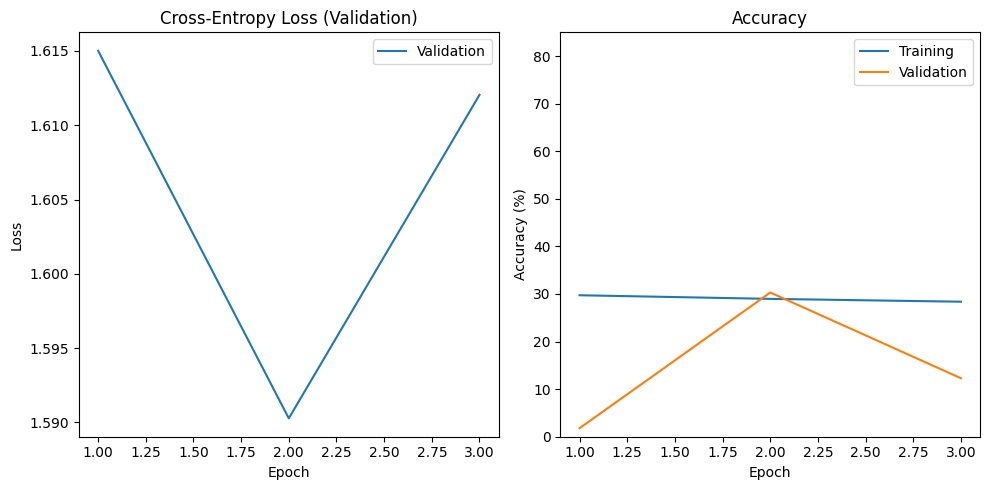

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross-Entropy Loss (Validation)')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), trn_acc_hist, label='Training')
plt.plot(range(1, num_epochs + 1), val_acc_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy')
plt.ylim(0, 85)

plt.tight_layout()
plt.show()

# **Test Evaluation:**

In [ ]:
evaluate(model, test_data)

838


100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


 Evaluation accuracy: 0.6921241050119332


0.6921241050119332

# LLMs:

In [ ]:
!pip install requests
!pip install transformers

## Medicine-chat:

In [ ]:
import requests
from transformers import AutoModelForCausalLM, AutoTokenizer

def consult_ai(age, sex, location, diagnosis):

    model = AutoModelForCausalLM.from_pretrained("AdaptLLM/medicine-chat")
    tokenizer = AutoTokenizer.from_pretrained("AdaptLLM/medicine-chat")
    
    user_input = f"""I am a patient with {diagnosis} disease on my {location} area of my body.
    I am {age} years old and my sex is {sex}. Apart from immediately consulting a doctor,
    what should my next steps be?"""
    
    our_system_prompt = "\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n" # Please do NOT change this
    prompt = f"<s>[INST] <<SYS>>{our_system_prompt}<</SYS>>\n\n{user_input} [/INST]"
    
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    outputs = model.generate(input_ids=inputs, max_length=4096)[0]
    
    answer_start = int(inputs.shape[-1])
    pred = tokenizer.decode(outputs[answer_start:], skip_special_tokens=True)

    print(pred)

consult_ai(18, "male", "behind ear", "Melanoma")

In [ ]:
import requests
from transformers import AutoModelForCausalLM, AutoTokenizer

# model = AutoModelForCausalLM.from_pretrained("AdaptLLM/medicine-chat")
# tokenizer = AutoTokenizer.from_pretrained("AdaptLLM/medicine-chat")

def consult_ai(age, sex, location, diagnosis):
    user_input = f"""I am a patient with {diagnosis} disease on my {location} area of my body.
    I am {age} years old and my sex is {sex}. Apart from immediately consulting a doctor,
    what should my next steps be?"""
    
    our_system_prompt = "\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n" # Please do NOT change this
    prompt = f"<s>[INST] <<SYS>>{our_system_prompt}<</SYS>>\n\n{user_input} [/INST]"
    
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    outputs = model.generate(input_ids=inputs, max_new_tokens=200)[0]

    answer_start = int(inputs.shape[-1])
    pred = tokenizer.decode(outputs[answer_start:], skip_special_tokens=True)
    
    print(pred)

consult_ai(65, "female", "on nose", "Bowen's Disease")

## Gemini:

In [ ]:
import google.generativeai as genai
import os

def consult_gemini(age, sex, location, diagnosis):
    user_input = f"""I am a patient with {diagnosis} disease on my {location} area of my body.
    I am {age} years old and my sex is {sex}. Apart from immediately consulting a doctor,
    what should my next steps be?"""
    
    genai.configure(api_key='ak') # Real API Key is hiddeb deliberately
    model = genai.GenerativeModel('gemini-pro')
    response = model.generate_content(user_input)
    
    print(response.text)

consult_gemini(65, "female", "on nose", "melanoma")